In [2]:
import os

import torch
# import torchvision
from torchvision.transforms import v2

# from torch import nn
# from torchsummary import summary

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

In [3]:
test_prop = 0.2
val_prop = 0.2

batch_size = 64

img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

test_prop = 19.99%
train_prop = 64.01%
val_prop = 16.00%
Percent cloudy = 55.052% (4844 / 8799)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


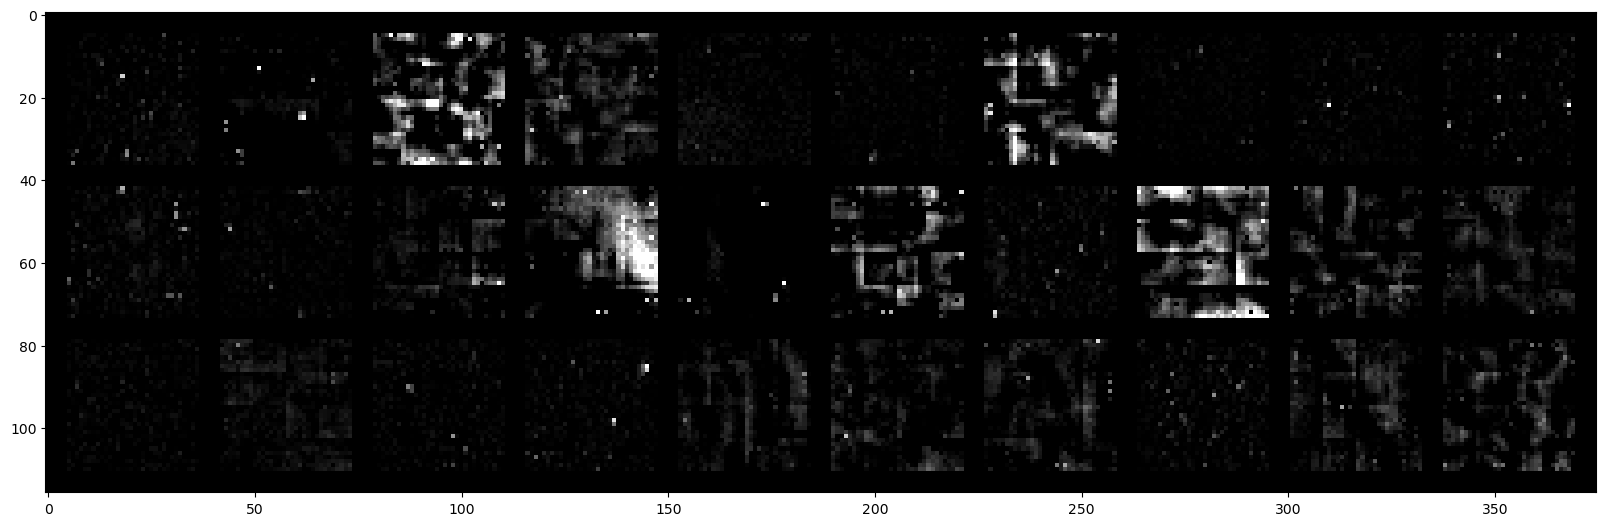

In [4]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=[0], std=[67]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])


labeled_data = CloudDetectionTrain(
    transform=transform
)
dataset_size = len(labeled_data)
dataset_indices = np.arange(dataset_size)

np.random.shuffle(dataset_indices)

# Test / Train split
test_split_index = int(np.floor(test_prop * dataset_size))
trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]

# Train / Val split
trainset_size = len(trainset_indices)
val_split_index = int(np.floor(val_prop * trainset_size))
train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]


test_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop = {100 * len(train_idx) / dataset_size:.2f}%\n'
      f'val_prop = {100 * len(val_idx) / dataset_size:.2f}%'
)

labeled_data.dsl_df
feature_uid = labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
labeled_data[0][0]
num_clear = len(labeled_data.dsl_df.loc[labeled_data.dsl_df.label == 'clear_night_sky'])
num_cloudy = len(labeled_data.dsl_df.loc[labeled_data.dsl_df.label == 'not_clear_cloudy'])
print(f'Percent cloudy = {100 *num_cloudy / len(labeled_data):.3f}% ({num_cloudy} / {len(labeled_data)})')

rn = np.random.choice(len(labeled_data), size=30, replace=False)
labeled_data.dataset_manager.main_dfs['feature']['batch_id'].unique()
images = [labeled_data[i][0][img_type] for i in rn]
plt.figure(figsize=(20,10))
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)));

In [5]:
# Training config

learning_rate = 0.001
# momentum=0.9

model = CloudDetection()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=20, gamma=0.9, do_summary=False,
    img_type=img_type
);



Epoch 1


  0%|          | 0/88 [00:00<?, ?batches/s]

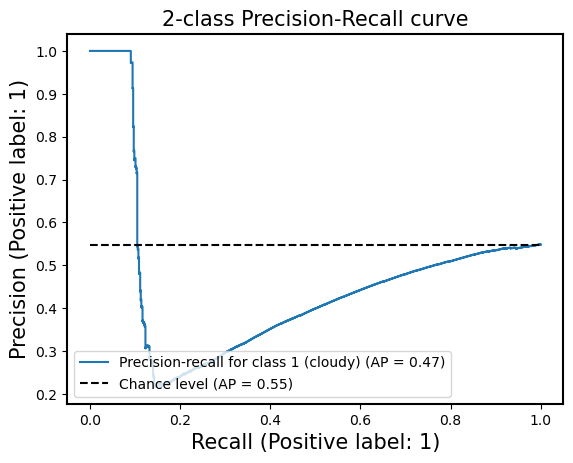

       Val: 	loss = 0.2239,  acc = 1319/1408 (93.68%) 
      Train: 	loss = 0.2315,  acc = 5268/5632 (93.54%)


Epoch 2


  0%|          | 0/88 [00:00<?, ?batches/s]

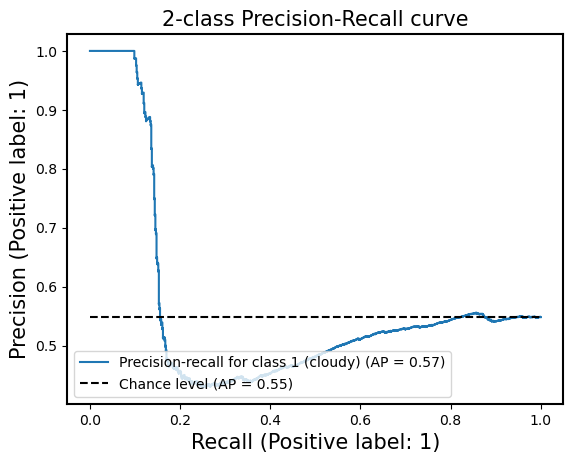

       Val: 	loss = 0.1832,  acc = 1354/1408 (96.16%) 
      Train: 	loss = 0.1775,  acc = 5381/5632 (95.54%)


Epoch 3


  0%|          | 0/88 [00:00<?, ?batches/s]

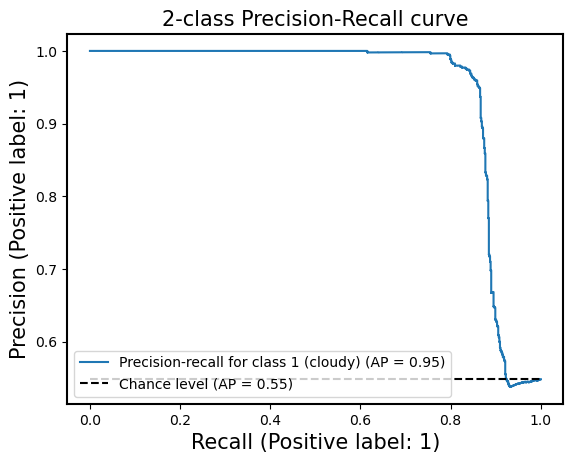

       Val: 	loss = 0.1645,  acc = 1354/1408 (96.16%) 
      Train: 	loss = 0.1600,  acc = 5413/5632 (96.11%)


Epoch 4


  0%|          | 0/88 [00:00<?, ?batches/s]

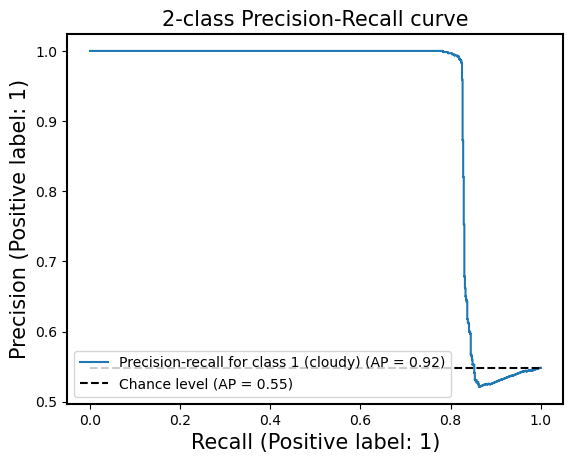

       Val: 	loss = 0.1751,  acc = 1351/1408 (95.95%) 
      Train: 	loss = 0.1734,  acc = 5416/5632 (96.16%)


Epoch 5


  0%|          | 0/88 [00:00<?, ?batches/s]

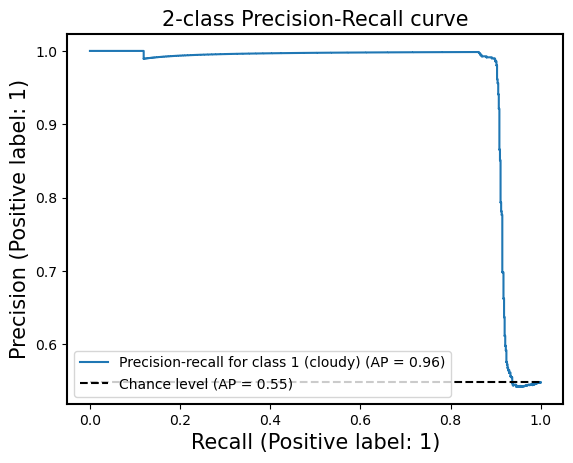

       Val: 	loss = 0.1748,  acc = 1349/1408 (95.81%) 
      Train: 	loss = 0.1700,  acc = 5395/5632 (95.79%)


Epoch 6


  0%|          | 0/88 [00:00<?, ?batches/s]

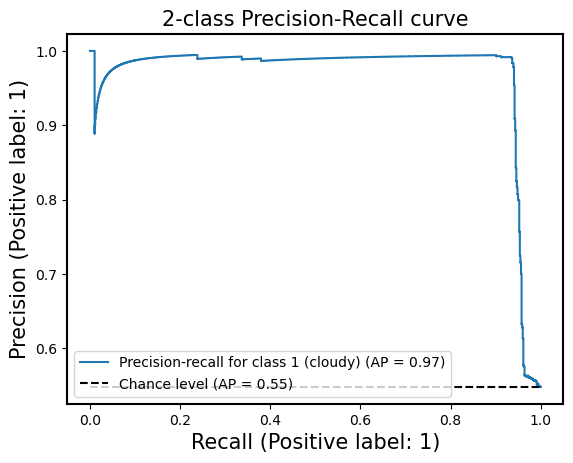

       Val: 	loss = 0.1672,  acc = 1364/1408 (96.88%) 
      Train: 	loss = 0.1636,  acc = 5467/5632 (97.07%)


Epoch 7


  0%|          | 0/88 [00:00<?, ?batches/s]

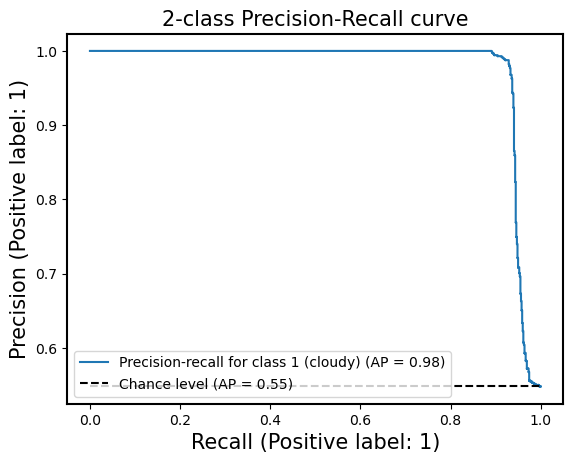

       Val: 	loss = 0.1186,  acc = 1370/1408 (97.30%) 
      Train: 	loss = 0.1216,  acc = 5467/5632 (97.07%)


Epoch 8


  0%|          | 0/88 [00:00<?, ?batches/s]

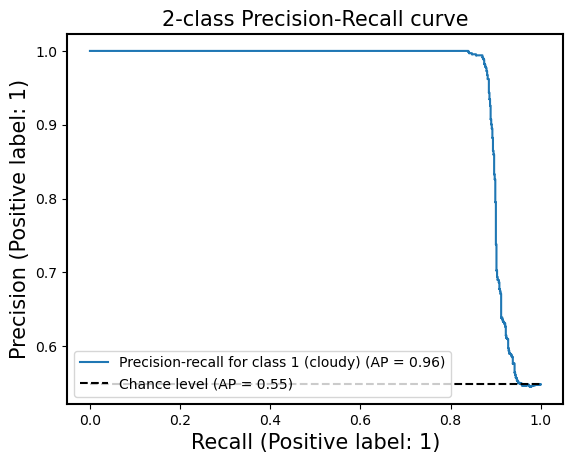

       Val: 	loss = 0.1394,  acc = 1364/1408 (96.88%) 
      Train: 	loss = 0.1411,  acc = 5444/5632 (96.66%)


Epoch 9


  0%|          | 0/88 [00:00<?, ?batches/s]

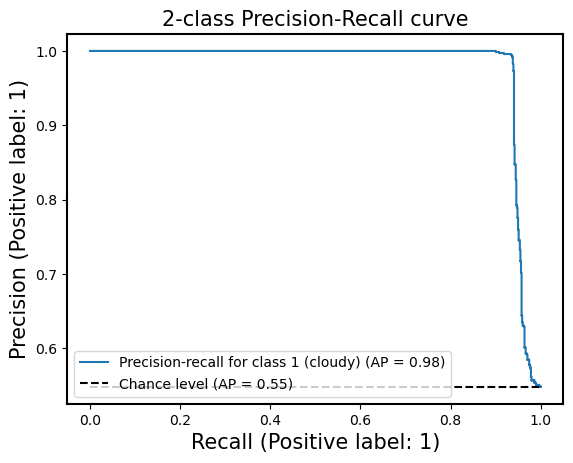

       Val: 	loss = 0.1205,  acc = 1372/1408 (97.44%) 
      Train: 	loss = 0.1189,  acc = 5495/5632 (97.57%)


Epoch 10


  0%|          | 0/88 [00:00<?, ?batches/s]

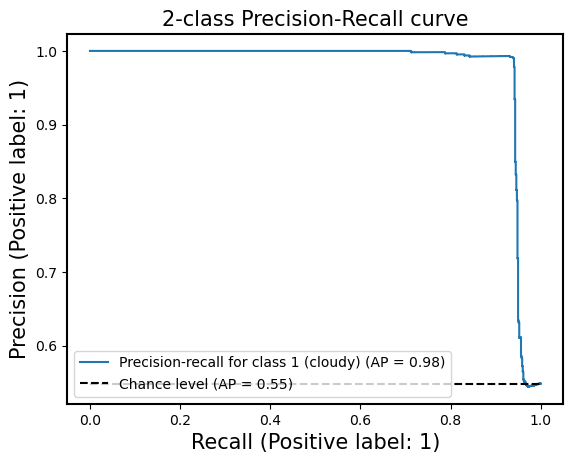

       Val: 	loss = 0.1494,  acc = 1365/1408 (96.95%) 
      Train: 	loss = 0.1492,  acc = 5452/5632 (96.80%)


Epoch 11


  0%|          | 0/88 [00:00<?, ?batches/s]

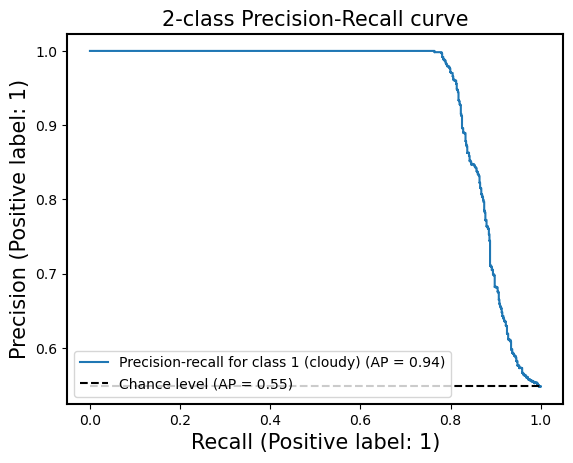

       Val: 	loss = 0.0910,  acc = 1371/1408 (97.37%) 
      Train: 	loss = 0.0918,  acc = 5496/5632 (97.59%)


Epoch 12


  0%|          | 0/88 [00:00<?, ?batches/s]

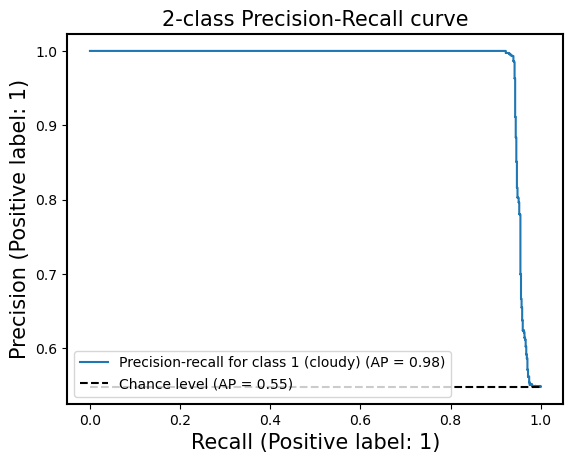

       Val: 	loss = 0.1486,  acc = 1374/1408 (97.59%) 
      Train: 	loss = 0.1500,  acc = 5489/5632 (97.46%)


Epoch 13


  0%|          | 0/88 [00:00<?, ?batches/s]

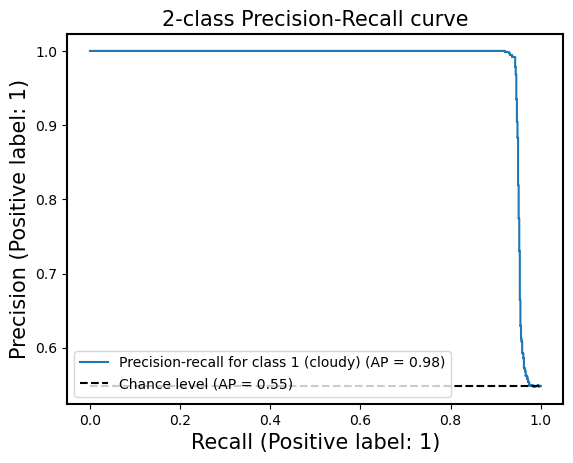

       Val: 	loss = 0.1134,  acc = 1372/1408 (97.44%) 
      Train: 	loss = 0.1119,  acc = 5485/5632 (97.39%)


Epoch 14


  0%|          | 0/88 [00:00<?, ?batches/s]

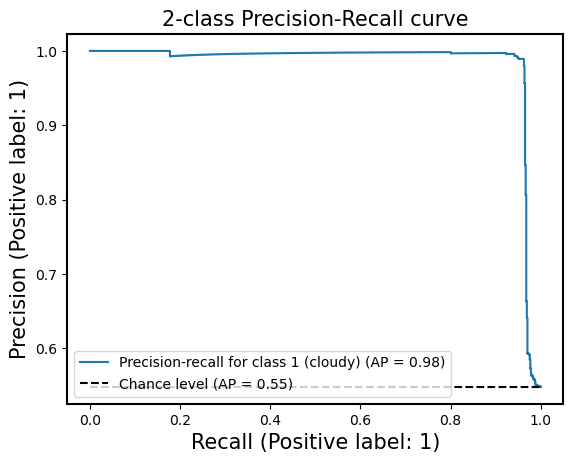

       Val: 	loss = 0.1258,  acc = 1374/1408 (97.59%) 
      Train: 	loss = 0.1216,  acc = 5502/5632 (97.69%)


Epoch 15


  0%|          | 0/88 [00:00<?, ?batches/s]

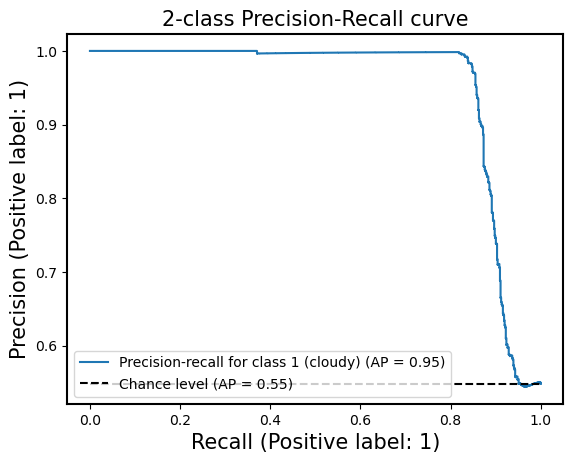

       Val: 	loss = 0.1032,  acc = 1374/1408 (97.59%) 
      Train: 	loss = 0.1040,  acc = 5487/5632 (97.43%)


Epoch 16


  0%|          | 0/88 [00:00<?, ?batches/s]

Keyboard Interrupt: Stopping training


In [6]:
trainer.train()

  0%|          | 0/28 [00:00<?, ?batches/s]

<Figure size 1500x1000 with 0 Axes>

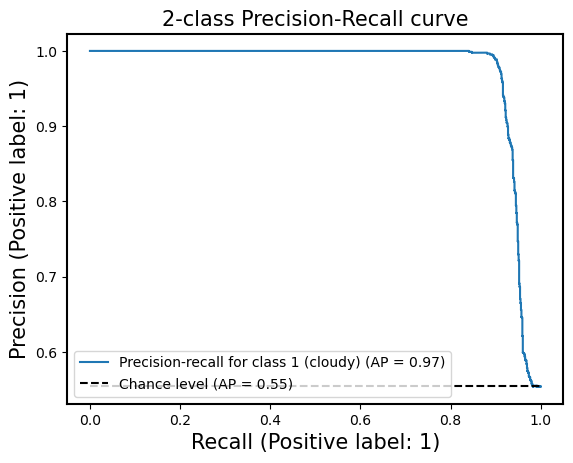

Test: 	loss = 0.1102,  acc = 1707/1759 (97.04%)


'Test: \tloss = 0.1102,  acc = 1707/1759 (97.04%)'

In [13]:
tester = Tester(model, loss_fn, test_loader, img_type)
tester.eval()

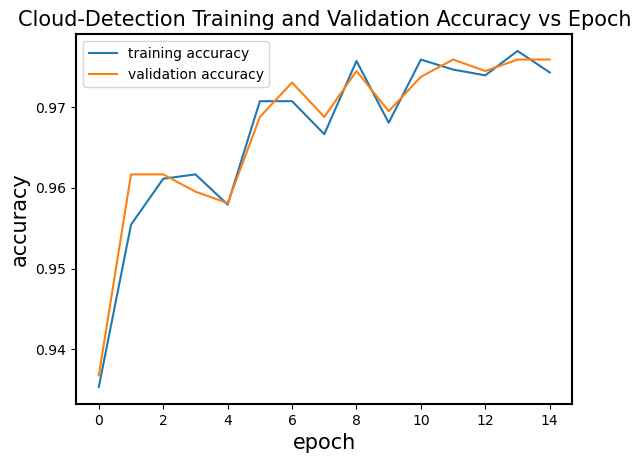

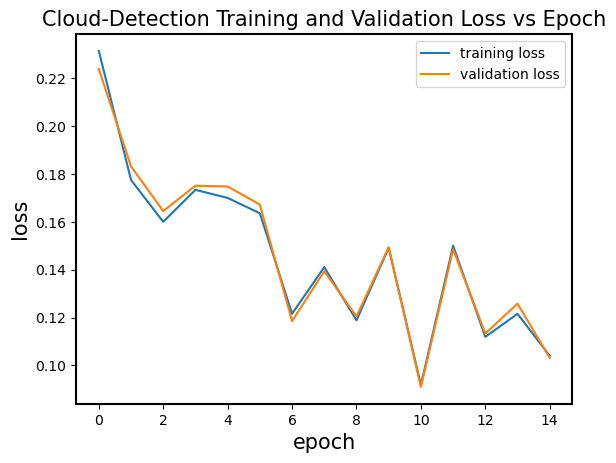

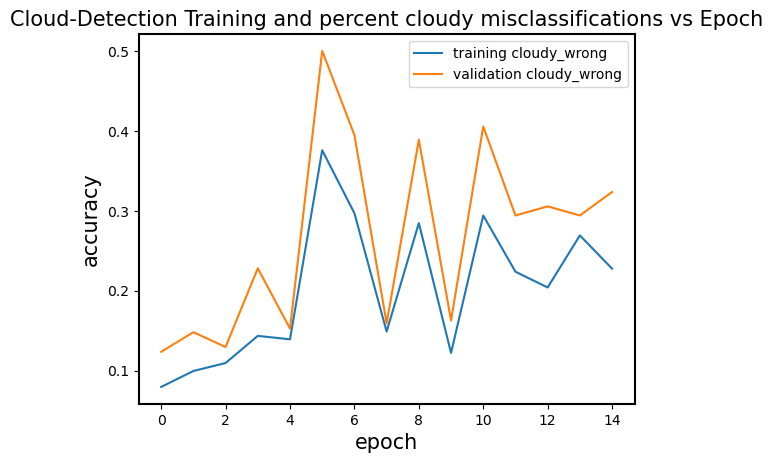

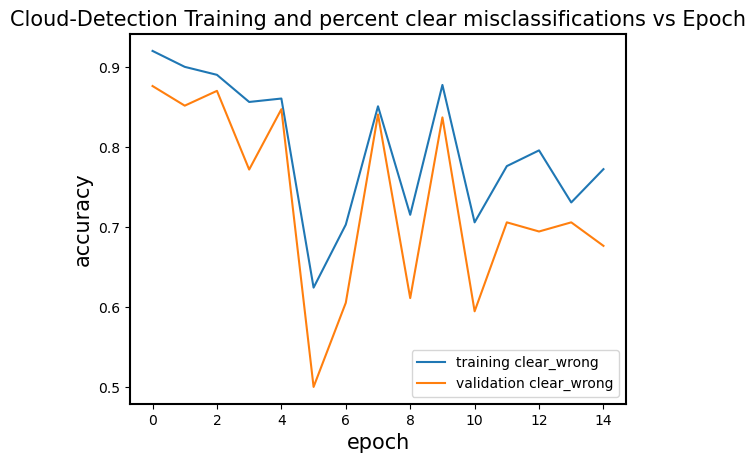

In [12]:
trainer.make_training_plots(do_save=False)